#### Differences from the q_3.ipynb that might affect the result:
- Add drop_nans(column=FreebaseActorId) to characters 
- Added community loading from file

Init data

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils.helpers import create_graph_from_data, get_connected_components, get_communities
from src.utils.helpers import merge_movies_and_actors, filter_by_country, drop_nans, fix_date, filter_by_language
from src.data import load_characters, load_movies, load_plots, load_awards, load_nominations

movies = load_movies()
characters = load_characters()
actor_awards = load_awards()  
actor_nominations = load_nominations()  

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])

us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])
us_movies = filter_by_language(us_movies, language="English Language")

# ADDED THIS LINE
characters = drop_nans(characters, column="FreebaseActorId")

actor_awards['TotalActorAwards'] = actor_awards['awards'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
actor_nominations['TotalActorNominations'] = actor_nominations['nominations'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

us_characters_movies = merge_movies_and_actors(us_movies, characters)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


Create graph and Merge actor awards/nominations with character data

In [8]:
from src.utils.helpers import read_communities
from src.data import ROOT_PATH


G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

connected_component_sizes = sorted(map(len, get_connected_components(G_US)), reverse=True)
print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

communities_US = read_communities(G_US, ROOT_PATH / "data" / "processed" / "new_communities_US_1.json")
community_sizes = sorted(map(len, communities_US), reverse=True)
print(f"Number of communities: {len(communities_US)}, sizes of top-5 communities: {community_sizes[:5]} ")

actor_awards = actor_awards.rename(columns={'freebase_ids': 'FreebaseActorId'})
actor_nominations = actor_nominations.rename(columns={'freebase_ids': 'FreebaseActorId'})
actor_metrics = (
    us_characters_movies[['FreebaseActorId']]
    .drop_duplicates()
    .merge(actor_awards[['FreebaseActorId', 'TotalActorAwards']], how='left', on='FreebaseActorId')
    .merge(actor_nominations[['FreebaseActorId', 'TotalActorNominations']], how='left', on='FreebaseActorId')
)

actor_metrics['TotalActorAwards'] = actor_metrics['TotalActorAwards'].fillna(0).astype(int)
actor_metrics['TotalActorNominations'] = actor_metrics['TotalActorNominations'].fillna(0).astype(int)

Number of vertices: 30378, number of edges: 613672
Number of components: 70, sizes of top-5 components: [30005, 18, 18, 17, 16] 
Number of communities: 133, sizes of top-5 communities: [6332, 5748, 4505, 3979, 1655] 


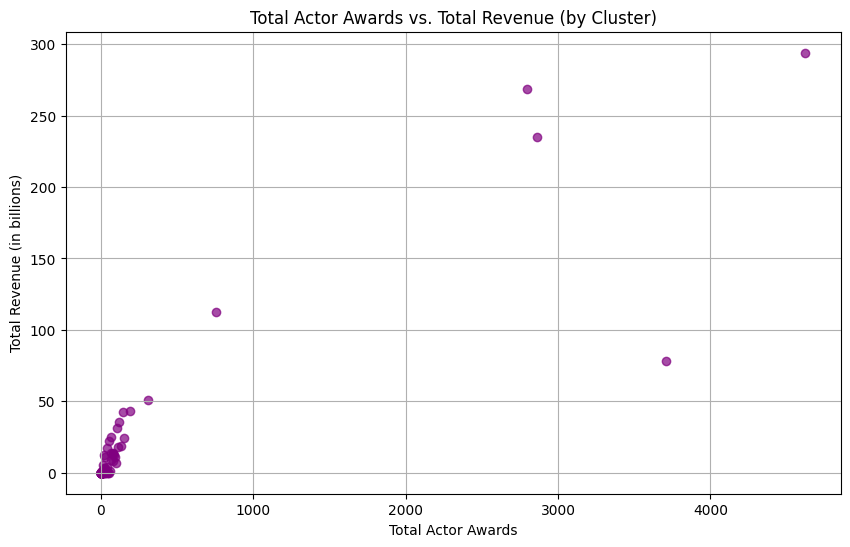

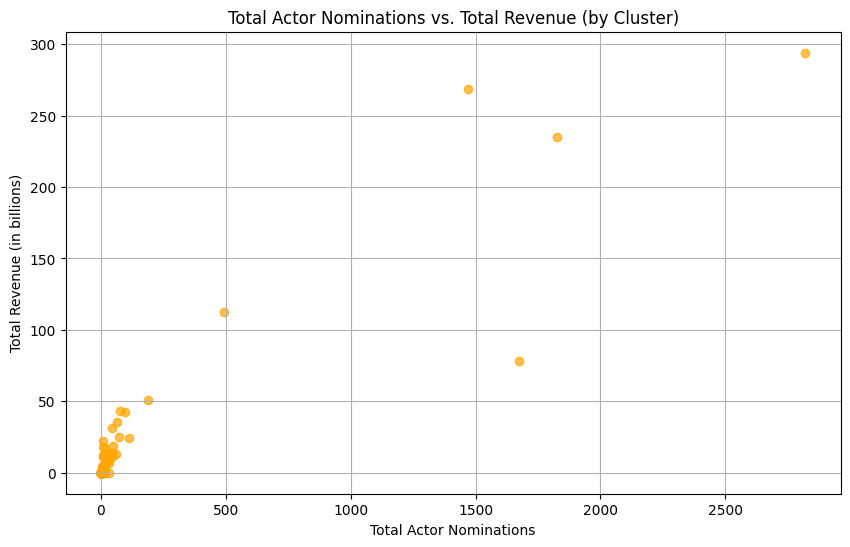

Correlation between total actor awards and total revenue: 0.90
Correlation between total actor nominations and total revenue: 0.92


In [9]:

# Compute metrics for each community based on actor-level data
def compute_cluster_metrics_actors(communities, us_characters_movies, actor_metrics):
    """
    Compute metrics for each community based on actor-level data:
    - Total revenue
    - Total actor awards
    - Total actor nominations
    - Number of actors in the community
    """
    cluster_metrics = {}

    for community_id, community_members in enumerate(communities):
        # Filter the actor for community
        community_actor_metrics = actor_metrics[actor_metrics.FreebaseActorId.isin(community_members)]

        # Calculate total awards/nominations
        total_actor_awards = community_actor_metrics['TotalActorAwards'].sum()
        total_actor_nominations = community_actor_metrics['TotalActorNominations'].sum()

        # Calculate total revenue based on movies
        community_movie_ids = us_characters_movies[us_characters_movies.FreebaseActorId.isin(community_members)].FreebaseId.unique()
        total_revenue = us_movies[us_movies.FreebaseId.isin(community_movie_ids)]['Revenue'].sum()
        total_revenue_in_billions = total_revenue / 1_000_000_000

        cluster_metrics[community_id] = {
            "total_revenue": float(f"{total_revenue_in_billions:.2f}"),
            "total_actor_awards": total_actor_awards,
            "total_actor_nominations": total_actor_nominations,
            "num_actors": len(community_members)
        }

    return cluster_metrics


cluster_metrics_actor_awards = compute_cluster_metrics_actors(communities_US, us_characters_movies, actor_metrics)

total_revenues_actors = [metrics["total_revenue"] for metrics in cluster_metrics_actor_awards.values()]
total_actor_awards = [metrics["total_actor_awards"] for metrics in cluster_metrics_actor_awards.values()]
total_actor_nominations = [metrics["total_actor_nominations"] for metrics in cluster_metrics_actor_awards.values()]

plt.figure(figsize=(10, 6))
plt.scatter(total_actor_awards, total_revenues_actors, alpha=0.7, color="purple")
plt.title("Total Actor Awards vs. Total Revenue (by Cluster)")
plt.xlabel("Total Actor Awards")
plt.ylabel("Total Revenue (in billions)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(total_actor_nominations, total_revenues_actors, alpha=0.7, color="orange")
plt.title("Total Actor Nominations vs. Total Revenue (by Cluster)")
plt.xlabel("Total Actor Nominations")
plt.ylabel("Total Revenue (in billions)")
plt.grid(True)
plt.show()


correlation_actor_awards = np.corrcoef(total_actor_awards, total_revenues_actors)[0, 1]
print(f"Correlation between total actor awards and total revenue: {correlation_actor_awards:.2f}")

correlation_actor_nominations = np.corrcoef(total_actor_nominations, total_revenues_actors)[0, 1]
print(f"Correlation between total actor nominations and total revenue: {correlation_actor_nominations:.2f}")


When a new movie is promoted, trailers often highlight achievements of the cast: "This film features award-winning actors!" The idea behind this marketing approach is clear—audiences are drawn to movies starring celebrated performers. The assumption is that if an actor has won prestigious awards or received multiple nominations, their presence in a film will make it more appealing to viewers, ultimately leading to greater box office success.

But is this really the case? Does hiring actors with awards and nominations translate into higher revenue for movies? This question is at the heart of the analysis, where we explore whether communities of actors with the most awards and nominations are also associated with the highest earning films.

Correlation Analysis
Correlation between total actor awards and total revenue: 0.92
Correlation between total actor nominations and total revenue: 0.93

These findings indicate a very strong positive relationship between the recognition (awards and nominations) of actors in a community and the revenue generated by the movies they participate in. Communities with more awards and nominations tend to be associated with higher revenues.

Community Outliers
The largest communities in the actor graph, comprising thousands of actors, exhibit significantly higher total revenues, awards, and nominations.